In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
from torch import nn
from sklearn.metrics import accuracy_score
from umap import UMAP

In [2]:
from cassava.transforms import get_test_transforms
from cassava.utils import make_confusion_matrix, plot_image, Unnormalize

In [3]:
from cassava.pipelines.train_model.nodes import score_model

In [4]:
%matplotlib inline

In [5]:
model = context.catalog.load('model')

2020-12-30 12:29:26,039 - kedro.io.data_catalog - INFO - Loading data from `model` (TorchLocalModel)...


In [6]:
model.load_state_dict(torch.load('../data/06_models/cv_folds/model_fold_0.pt'))

<All keys matched successfully>

In [10]:
model = model.eval()

In [11]:
train = context.catalog.load('train')

2020-12-30 12:30:40,019 - kedro.io.data_catalog - INFO - Loading data from `train` (ImageOneFolderDataSet)...


In [12]:
parameters = context.catalog.load('parameters')

2020-12-30 12:30:40,238 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [15]:
train.transform = get_test_transforms(parameters['classifier']['test_width'], parameters['classifier']['test_height'])

In [16]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Predict on random image

In [17]:
def predict(model, x, invtemp=1):
    logits = model.forward(x)
    probabilities = nn.functional.softmax(invtemp*logits, dim=1)
    return probabilities

def pred_label(model, x, invtemp=1):
    return torch.max(predict(model, x, invtemp=invtemp), 1)[1]

def predict_diff_temps(model, x, invtemps):
    logits = model.forward(x)
    
    return {
        temp: nn.functional.softmax(temp*logits, dim=1) for temp in invtemps
    }


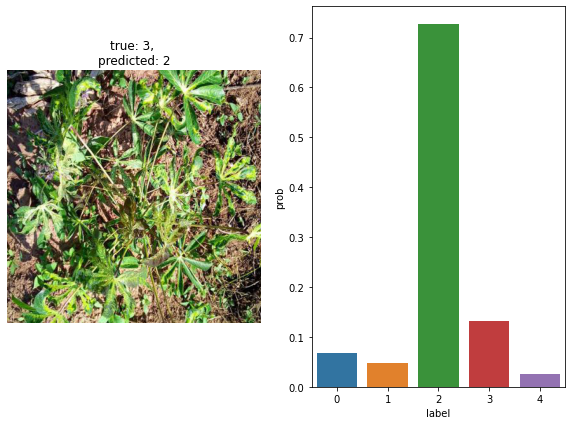

In [27]:
random_idx = np.random.choice(range(len(train)))
image, label = train[random_idx]

probabilities = predict(model, image.unsqueeze(0), invtemp=0.5)[0]
prediction = pred_label(model, image.unsqueeze(0)).item()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plot_image(unnorm(image), label=f"true: {label}, \npredicted: {prediction}")
plt.subplot(1, 2, 2)
sns.barplot(y=probabilities.detach().numpy(), x=list(range(5)))
plt.xlabel('label')
plt.ylabel('prob')
plt.show()

# Calibration curves

In [28]:
from sklearn.calibration import calibration_curve

In [29]:
from cassava.utils import DatasetFromSubset

In [42]:
indices = np.random.choice(range(len(train)), 5000)

In [43]:
train.transform = None

In [44]:
dataset = DatasetFromSubset(torch.utils.data.Subset(train, indices=indices),
                      transform=get_test_transforms(parameters['classifier']['test_width'], parameters['classifier']['test_height']))
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [45]:
predictions = {}
true_labels = []

invtemps = [0.75, 1, 1.25]

for temp in invtemps:
    predictions[temp] = []

model.eval()
for images, labels in tqdm(loader):
    preds =  predict_diff_temps(model, images, invtemps)
    for temp in invtemps:
        predictions[temp] += preds[temp].tolist()
    true_labels += labels.tolist()

100%|██████████| 500/500 [07:51<00:00,  1.06it/s]


In [46]:
for temp in invtemps:
    predictions[temp] = np.array(predictions[temp])
true_labels = np.array(true_labels)

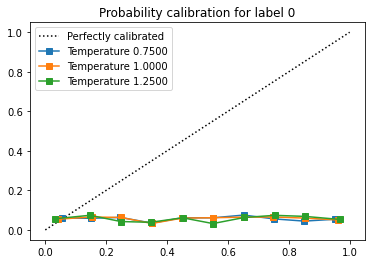

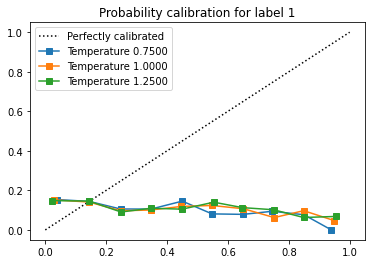

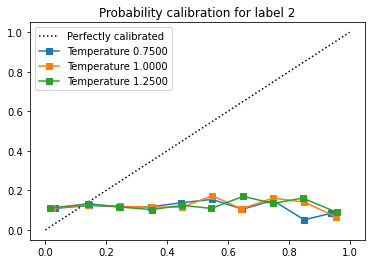

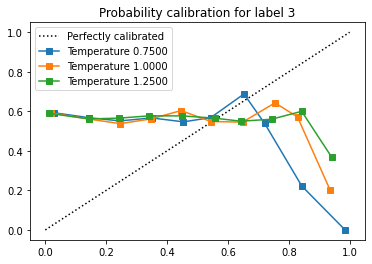

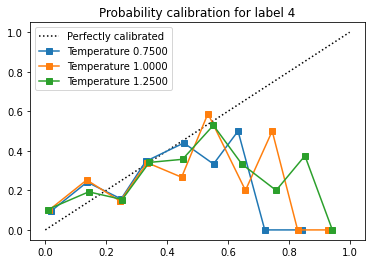

In [47]:
for label in [0, 1, 2, 3, 4]:
    plt.figure()
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.title(f'Probability calibration for label {label}')
    true_label = (true_labels == label)
    
    for temp in invtemps:
        pred_prob = predictions[temp][:, label]
    
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(true_label, pred_prob, n_bins=10)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Temperature {temp:0.4f}")
    plt.legend()
    plt.show()